# Comparing iNaturalist to Schiller maps



The Schiller map also performs well in comparison to sPlotOpen. These maps were produced to verify the efficacy of using a machine learning approach to estimate plant traits from photographs (Schiller et al, 2021). How well to these two maps compare to sPlotOpen? Are there regional differences in how well the Wolf and Schiller map perform? How do the two maps compare?

- Compare differences of Schiller and iNaturalist maps to sPlotOpen maps, respectively
- Compare Schiller and iNaturalist maps

In [ ]:
# packages
import os
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for calculating grid areas
from pyproj import Proj # allows for different projections 
from shapely.geometry import shape # for calculating areas
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import xarray as xr

In [3]:
from os import listdir
from os.path import isfile, join
path = "published_maps/2deg/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [4]:
files

['other_nit_2deg.tif', 'other_nita_2deg.tif', 'other_sla_2deg.tif']

In [5]:
def cubeFile(file):
    name = file.replace(".tif","")
    sr = xr.open_dataset(path + file,engine = "rasterio",chunks = 1024)
    sr = sr.assign_coords({"variable":name})
    return sr

da = xr.concat([cubeFile(x) for x in files],dim = "variable")

In [6]:
da

<xarray.Dataset>
Dimensions:      (band: 6, x: 180, y: 90, variable: 3)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6
  * x            (x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * y            (y) float64 89.0 87.0 85.0 83.0 ... -83.0 -85.0 -87.0 -89.0
    spatial_ref  int64 0
  * variable     (variable) <U15 'other_nit_2deg' ... 'other_sla_2deg'
Data variables:
    band_data    (variable, band, y, x) float32 dask.array<chunksize=(1, 6, 90, 180), meta=np.ndarray>

In [7]:
def plot_grid(df, lon, lat, variable, dataset_name, deg, log=True):
    
    
    plt.rcParams.update({'font.size': 15})

    # define raster shape for plotting
    step = int((360/deg) + 1)
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))


    df['x_bin'] = pd.cut(df[lon], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)

    df['x_bin'] = df['x_bin'].apply(lambda x: x.left)
    df['y_bin'] = df['y_bin'].apply(lambda x: x.left)

    grouped_df = df.groupby(['x_bin', 'y_bin'], as_index=False)[variable].max()
    raster = grouped_df.pivot('y_bin', 'x_bin', variable)

    # data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels = MaxNLocator(nbins=15).tick_values(grouped_df[variable].min(), grouped_df[variable].max())
    cmap = plt.get_cmap('PiYG') # colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) 
    im_ratio = raster.shape[0]/raster.shape[1] # for size of colorbar

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
        
    vmin=df[variable].min()
    if abs(df[variable].max()) > abs(vmin):
        vmin = df[variable].max()*-1
        vmax = df[variable].max()
    else:
        vmax = df[variable].min()*-1
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, raster, cmap=cmap, 
                       vmin=vmin,
                       vmax=vmax,
                        #vmin=-1.5,
                       #vmax=1.5,
                       transform=data_crs) 
    
    #add color bar
    if log==True:
            label= "ln " + str(variable)
    else:
        label= str(variable)
    
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label)

    #add coastlines
    ax.coastlines(resolution='110m', color='pink', linewidth=1.5)

    #set title
    ax.set_title( variable + ' ' + dataset_name, size=14)


In [8]:
def plot_hist_overlay_3(df, variable1, variable2, variable3, trait):
    
    v1 = df[variable1]
    v2 = df[variable2]
    v3 = df[variable3]

    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    ax3=fig.add_subplot(111, label="2", frame_on=False)



    ax.hist(v1, range=(v1.dropna().min(), v1.dropna().max()), bins=70, color="blue", alpha = 0.5)
    ax.set_xlabel("Trait value", color="black")
    ax.set_ylabel("Trait value frequency", color="black")
    ax.tick_params(axis='x', colors="black")
    ax.tick_params(axis='y', colors="black")
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])

    ax2.hist(v2, range=(v1.dropna().min(), v1.dropna().max()), bins=70, color="pink", alpha = 0.5)
    #ax2.xaxis.tick_top()
    #ax2.yaxis.tick_right()
    #ax2.tick_params(axis='y', colors="C1")
    #ax2.set_xlabel(variable2, color="C1")      
    #ax2.xaxis.set_label_position('top') 
    #ax2.tick_params(axis='x', colors="C1")
    ax2.set_ylim([y_min, y_max])
    
    ax3.hist(v3, range=(v1.dropna().min(), v1.dropna().max()), bins=70, color="black", alpha = 0.5)
    ax3.set_ylim([y_min, y_max])
    
    
    
    fig.legend(labels=["iNaturalist (Wolf)", "Schiller et al", "sPlotOpen"], loc='center left', bbox_to_anchor=(0.75, 0.5))

    plt.title(label= trait + " distributions sPlotOpen/Wolf/Schiller", fontsize=14)
    

In [10]:
def lat_weights(lat_unique, deg):
    
    from pyproj import Proj
    from shapely.geometry import shape

    # determine weights per grid cell based on longitude
    # keep only one exemplary cell at each distance from equator
    # weights per approximated area of grid size depending on distance from equator
    
    # make dictionary
    weights = dict()

    for j in lat_unique:
        
        # the four corner points of the grid cell
        
        p1 = (0 , j+(deg/2))
        p2 = (deg , j+(deg/2))
        p3 = (deg, j-(deg/2))
        p4 = (0, j-(deg/2))
        
        # Calculate polygon surface area
        # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
        
        # Define corner points
        co = {"type": "Polygon", "coordinates": [[p1,p2,p3,p4]]}
        lat_1=p1[1]
        lat_2=p3[1]
        lat_0=(p1[1]+p3[1])/2
        lon_0=deg/2
        
        # Caveat: Connot go accross equator
        value1 = abs(lat_1 + lat_2)
        value2 = abs((lat_1) + abs(lat_2))
        
        # if grid cell overlaps equator:
        if value1 < value2:
            
            lat_1=p1[1]
            lat_2=0
            lat_0=(p1[1]+lat_2)/2
            lon_0=deg/2
            
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)*2
        
        # if grid cell is on one side of equator:
        else:
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)

        
        # set coord to center of grid cell
        coord = j
        
        # map area to weights dictionary
        weights[coord] = area
    
    # convert area into proportion with area/max.area:
    max_area = max(weights.values())
    
    for key in weights.keys():
        
        weights[key] = weights[key]/max_area
        
    return weights

In [11]:
def weighted_r(df, col_1, col_2, col_lat, weights, r2=False):
    
    # map weights to dataframe
    df['Weights'] = df[col_lat].map(weights)
    
    # drop nan
    df = df.dropna()
    
    # calculate weighted correlation 
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
    import statsmodels.api as statmod
    
    d1 = statmod.stats.DescrStatsW( df[[col_1, col_2]], df['Weights'] )
        
    corr = d1.corrcoef[0][1]
    
    # optional
    # calculate r2
    if r2 == True:
        corr = corr**2
    
    return corr

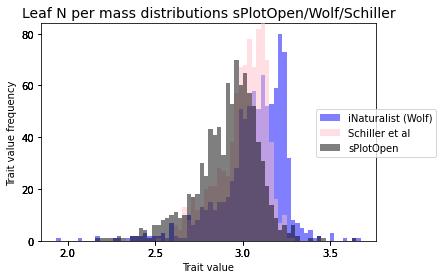

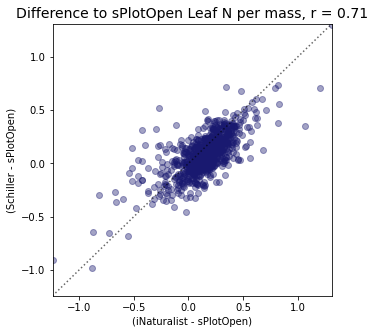

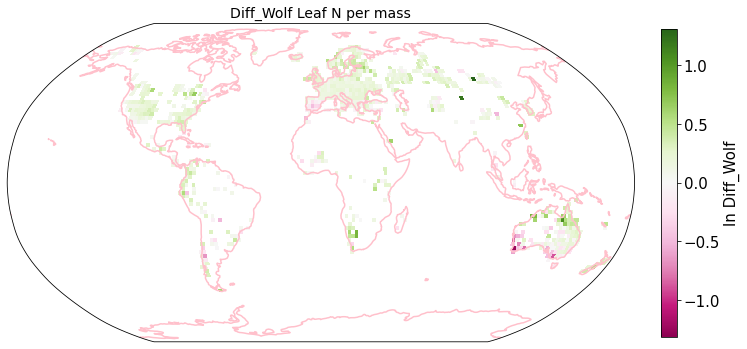

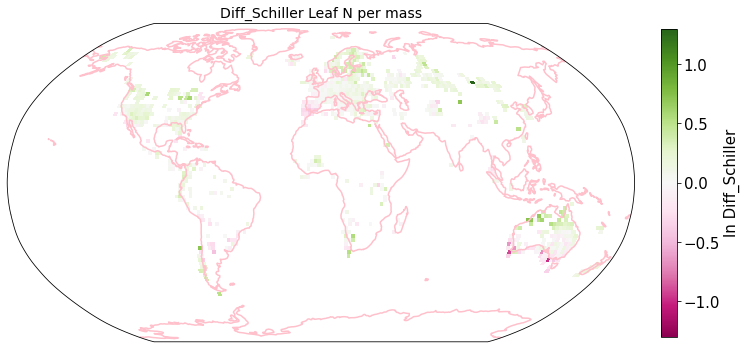

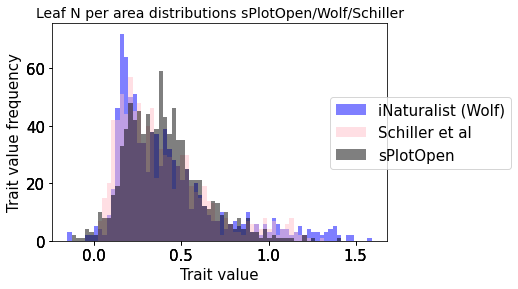

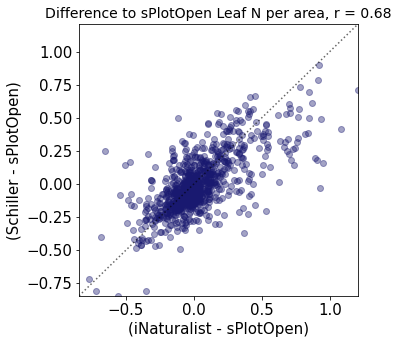

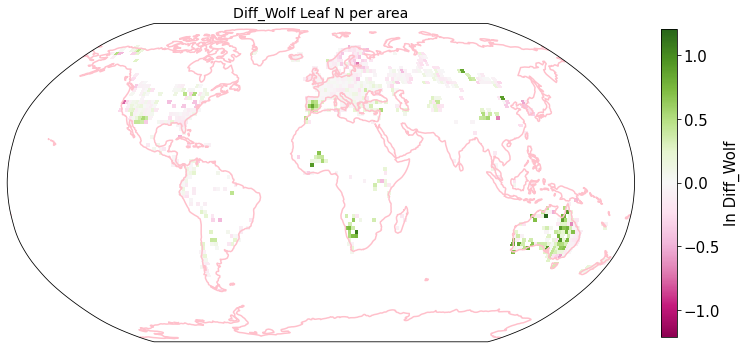

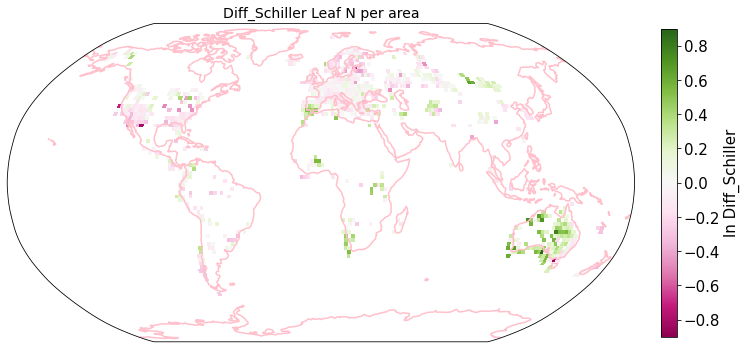

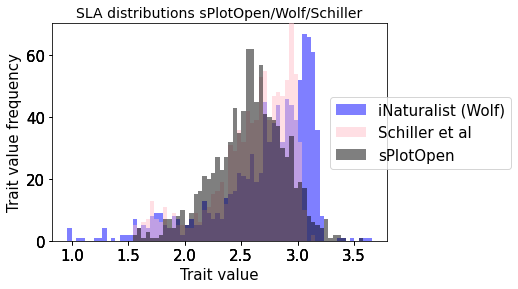

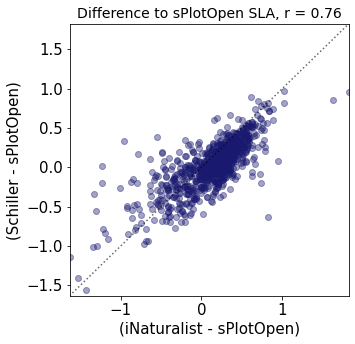

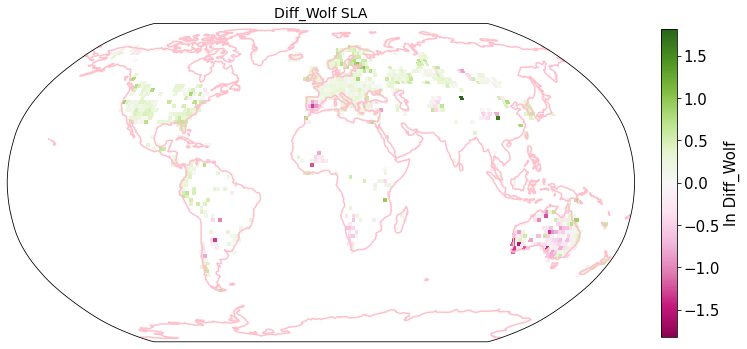

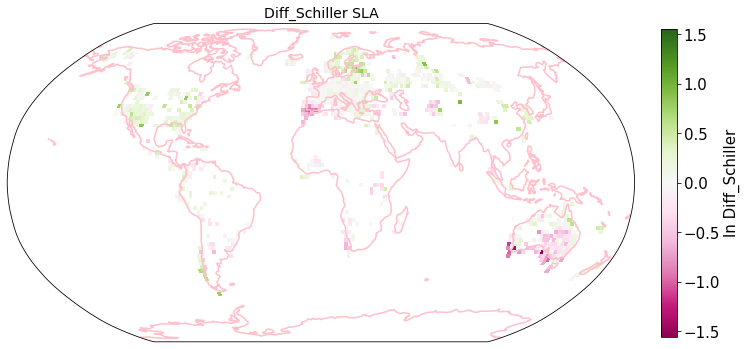

In [13]:
other_trait = ['other_nit_2deg', 'other_nita_2deg', 'other_sla_2deg']
trait = ['Leaf N per mass', 'Leaf N per area', 'SLA']

deg = 2

for b in [6]:
    
    for t in [0,1,2]:
        
        b = 4
        if t==2:
            b=6
        # open sPlotData

        filename="grid_means_" + str(deg) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==trait[t]]
        

        # published data
        
        df = da.sel(band = b).band_data.sel(variable = other_trait[t]).to_dataset().to_dataframe().reset_index()
        df['variable'] = trait[t]
        df['band_data'] = np.log(df['band_data'])        
        
        raster_means_trait = pd.merge(raster_means_trait, df, left_on = ["Trait","x_bin", "y_bin"], right_on = ["variable", "x", "y"])
        raster_means_trait.drop(["variable", "x", "y", "spatial_ref", "band"], axis=1, inplace=True)
            
        # drop nan's
        raster_means_trait = raster_means_trait.dropna()
        

        # difference maps
        raster_means_trait["Diff_Wolf"] = raster_means_trait["TraitValue_iNat"] - raster_means_trait["TraitValue_sPlot"]
        raster_means_trait["Diff_Schiller"] = raster_means_trait["band_data"] - raster_means_trait["TraitValue_sPlot"]
        
        # plot trait distribution
        
        plot_hist_overlay_3(raster_means_trait, "TraitValue_iNat", "band_data", "TraitValue_sPlot", trait[t])
        
        filename = "../Figures/" + other_trait[t] + "_hist_schiller_sPlot.pdf"
        plt.savefig(filename, bbox_inches='tight')
        
        
        # plot differences against eachother
        
        # get correlation
        # open saved raster mean files
        filename="grid_means_" + str(2) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        # determine weights per grid cell based on longitude
    
        lat_unique = raster_means['y_bin'].unique()
        weights = lat_weights(lat_unique, deg=2)
        
        r2_trait = weighted_r(raster_means_trait, "Diff_Wolf", "Diff_Schiller", "y_bin", weights)
        
        # difference to sPlot Open
        fig = plt.figure(figsize=(5, 5))
        ax = plt.scatter(raster_means_trait["Diff_Wolf"], raster_means_trait["Diff_Schiller"], 
                         alpha = 0.4, color="midnightblue")
        plt.axline([0,0], [1,1], color= "black", alpha=0.6, ls = ":")
        xlim1 = min(raster_means_trait["Diff_Wolf"])
        xlim2 = max(raster_means_trait["Diff_Wolf"])
        if xlim1>min(raster_means_trait["Diff_Schiller"]):
            xlim1 = min(raster_means_trait["Diff_Schiller"])
        if xlim2<max(raster_means_trait["Diff_Schiller"]):
            xlim2 = max(raster_means_trait["Diff_Schiller"])
        plt.xlim(xlim1,xlim2)
        plt.ylim(xlim1,xlim2)
        plt.title(label="Difference to sPlotOpen " + trait[t]+ ", r = " + str(round(r2_trait,2)),fontsize=14,color="black")
        plt.xlabel('(iNaturalist - sPlotOpen)')
        plt.ylabel('(Schiller - sPlotOpen)')
        
        filename = "../Figures/" + other_trait[t] + "_diff_corr_schiller.pdf"
        plt.savefig(filename, bbox_inches='tight')
        
        
        fig = plt.figure(figsize=(12, 12))
        plot_grid(raster_means_trait, 'x_bin', 'y_bin', 'Diff_Wolf', trait[t], deg=deg, log=True)
        
        fig = plt.figure(figsize=(12, 12))
        plot_grid(raster_means_trait, 'x_bin', 'y_bin', 'Diff_Schiller', trait[t], deg=deg, log=True)
        
        
        

## Compare Schiller and Wolf maps

### Load iNaturalist maps from geotiff

In [14]:
from os import listdir
from os.path import isfile, join
path = "./iNaturalist_traits-main/iNat_log/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [15]:
files

['iNat_Conduit.element.length_2_ln.tif',
 'iNat_Dispersal.unit.length_2_ln.tif',
 'iNat_LDMC_2_ln.tif',
 'iNat_Leaf.Area_2_ln.tif',
 'iNat_Leaf.C_2_ln.tif',
 'iNat_Leaf.N.P.ratio_2_ln.tif',
 'iNat_Leaf.N.per.area_2_ln.tif',
 'iNat_Leaf.N.per.mass_2_ln.tif',
 'iNat_Leaf.P_2_ln.tif',
 'iNat_Leaf.delta15N_2_ln.tif',
 'iNat_Leaf.fresh.mass_2_ln.tif',
 'iNat_Plant.Height_2_ln.tif',
 'iNat_SLA_2_ln.tif',
 'iNat_SSD_2_ln.tif',
 'iNat_Seed.length_2_ln.tif',
 'iNat_Seed.mass_2_ln.tif',
 'iNat_Seeds.per.rep..unit_2_ln.tif',
 'iNat_Stem.conduit.density_2_ln.tif']

In [16]:
def cubeFile(file):
    name = file.replace(".tif","")
    sr = xr.open_dataset(path + file,engine = "rasterio",chunks = 1024).sel(band = 1)
    sr = sr.assign_coords({"variable":name})
    return sr

da_2 = xr.concat([cubeFile(x) for x in files],dim = "variable")

In [17]:
da_2

<xarray.Dataset>
Dimensions:      (x: 180, y: 90, variable: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * y            (y) float64 89.0 87.0 85.0 83.0 ... -83.0 -85.0 -87.0 -89.0
    spatial_ref  int64 0
  * variable     (variable) <U32 'iNat_Conduit.element.length_2_ln' ... 'iNat...
Data variables:
    band_data    (variable, y, x) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

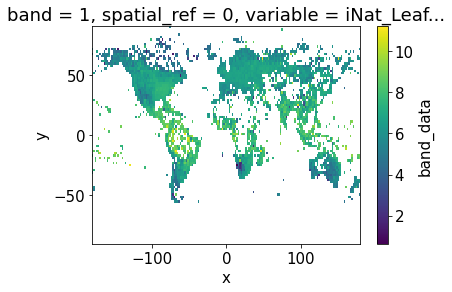

In [18]:
da_2.band_data.sel(variable = "iNat_Leaf.Area_2_ln").plot.imshow()

In [19]:
df = da_2.band_data.to_dataset().to_dataframe().reset_index()

In [20]:
df_spread = df.pivot(index= ['x','y'],columns='variable',values='band_data').reset_index()

In [21]:
df_spread.head()

variable,x,y,iNat_Conduit.element.length_2_ln,iNat_Dispersal.unit.length_2_ln,iNat_LDMC_2_ln,iNat_Leaf.Area_2_ln,iNat_Leaf.C_2_ln,iNat_Leaf.N.P.ratio_2_ln,iNat_Leaf.N.per.area_2_ln,iNat_Leaf.N.per.mass_2_ln,iNat_Leaf.P_2_ln,iNat_Leaf.delta15N_2_ln,iNat_Leaf.fresh.mass_2_ln,iNat_Plant.Height_2_ln,iNat_SLA_2_ln,iNat_SSD_2_ln,iNat_Seed.length_2_ln,iNat_Seed.mass_2_ln,iNat_Seeds.per.rep..unit_2_ln,iNat_Stem.conduit.density_2_ln
0,-179.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-179.0,-87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-179.0,-85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-179.0,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-179.0,-81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot differences of Wolf and Schiller maps

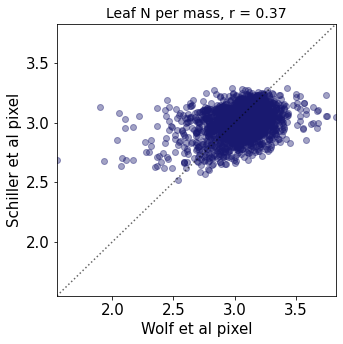

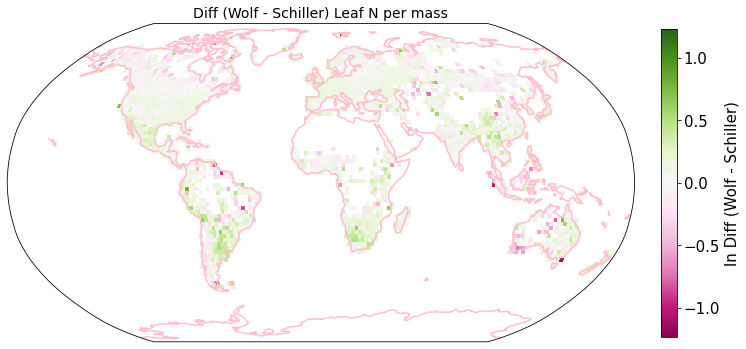

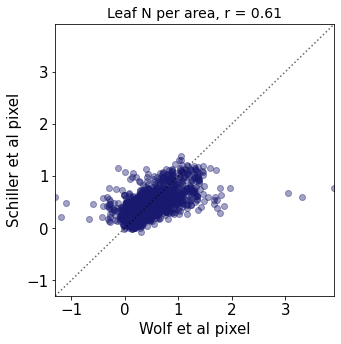

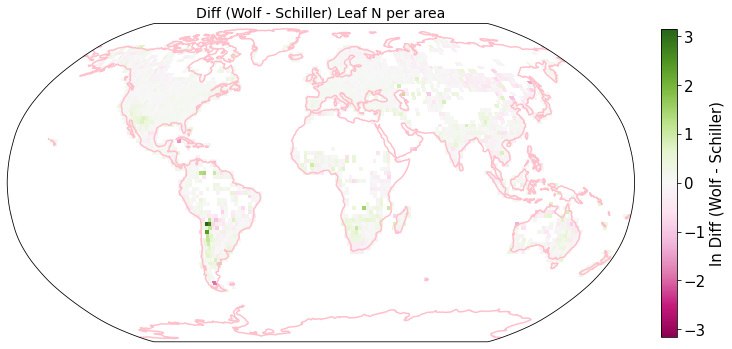

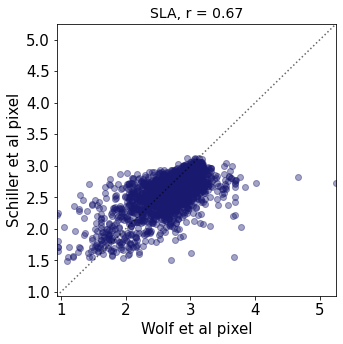

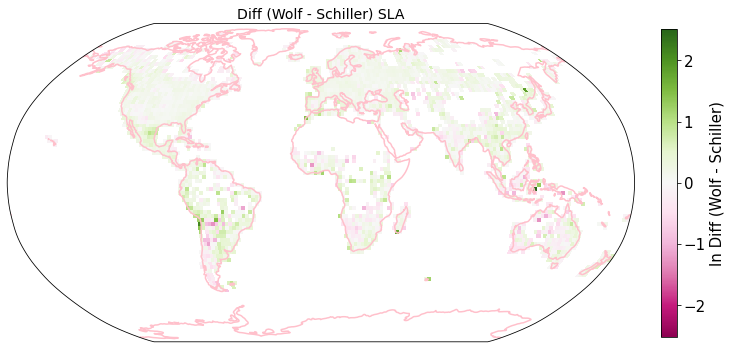

In [23]:
other_trait = ['other_nit_2deg', 'other_nita_2deg', 'other_sla_2deg']
trait = ['iNat_Leaf.N.per.mass_2_ln', 'iNat_Leaf.N.per.area_2_ln', 'iNat_SLA_2_ln']
label = ['Leaf N per mass', 'Leaf N per area', 'SLA']

deg = 2

for b in [6]:
    
    for t in [0,1,2]:
        
        b = 4
        if t==2:
            b=6

        # published data
        
        schiller = da.sel(band = b).band_data.sel(variable = other_trait[t]).to_dataset().to_dataframe().reset_index()
        schiller['variable'] = trait[t]
        schiller['band_data'] = np.log(schiller['band_data'])        
        
        wolf = da_2.band_data.sel(variable = trait[t]).to_dataframe().reset_index()
        
        raster_means_trait = pd.merge(wolf, schiller, on = ["variable", "x", "y"])
        
        # difference maps
        raster_means_trait["Diff (Wolf - Schiller)"] = raster_means_trait["band_data_x"] - raster_means_trait["band_data_y"]
        
        # drop nan's
        raster_means_trait = raster_means_trait.dropna()
        
        # plot differences against eachother
        
        # get correlation
        # open saved raster mean files
        filename="grid_means_" + str(2) + "_deg.csv"
        raster_means = pd.read_csv(filename)
        raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
        # determine weights per grid cell based on longitude
    
        lat_unique = raster_means['y_bin'].unique()
        weights = lat_weights(lat_unique, deg=2)
        
        r2_trait = weighted_r(raster_means_trait, "band_data_x", "band_data_y", "y", weights)
        
        fig = plt.figure(figsize=(5, 5))
        ax = plt.scatter(raster_means_trait["band_data_x"], raster_means_trait["band_data_y"], 
                         alpha = 0.4, color="midnightblue")
        plt.axline([0,0], [1,1], color= "black", alpha=0.6, ls = ":")
        xlim1 = min(raster_means_trait["band_data_x"])
        xlim2 = max(raster_means_trait["band_data_x"])
        if xlim1>min(raster_means_trait["band_data_y"]):
            xlim1 = min(raster_means_trait["band_data_y"])
        if xlim2<max(raster_means_trait["band_data_y"]):
            xlim2 = max(raster_means_trait["band_data_y"])
        plt.xlim(xlim1,xlim2)
        plt.ylim(xlim1,xlim2)
        plt.title(label=label[t]+ ", r = " + str(round(r2_trait,2)),fontsize=14,color="black")
        plt.xlabel('Wolf et al pixel')
        plt.ylabel('Schiller et al pixel')
        

        filename = "../Figures/" + other_trait[t] + "_corr_schiller_wolf.pdf"
        plt.savefig(filename, bbox_inches='tight')
        
        fig = plt.figure(figsize=(12, 12))
        plot_grid(raster_means_trait, 'x', 'y', 'Diff (Wolf - Schiller)', label[t], deg=deg, log=True)
        

        